# GPU vs CPU benchmark
### single-layer Earth atmosphere, $H_2 O$
### Using HITRAN, `jax`, and NVIDIA GPUs


In [1]:
import astropy.units as u
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import hapi
hapi.db_begin('../../hapi/data/')

from jax.config import config
config.update("jax_enable_x64", True)

import jax.numpy as np
from jax import vmap, jit, grad, random
from jax.lax import stop_gradient
from jax import jacfwd
from functools import partial

HAPI version: 1.1.0.9.7
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2017 are now available in HAPI code

           It is free to use HAPI. If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005
Using ../../hapi/data/

H2O
                     Lines parsed: 70039
CO2
                     Lines parsed: 69523
O2
                     Lines parsed: 679


In [2]:
@jit
def gamma_of_p_and_T(p, T, p_self, n_air, gamma_air_ref, gamma_self_ref):
    '''Compute the Lorentz HWHM with pressure and temp'''
    return (296.0/T)**n_air *(gamma_air_ref*(p-p_self) + gamma_self_ref*(p_self))

In [3]:
@jit
def lorentz_profile(nu, p, nu_ij, gamma, dp_ref, S_ij):
    '''Return the Lorentz line profile given vectors and parameters'''
    return S_ij/np.pi * gamma / ( gamma**2 + (nu - (nu_ij + dp_ref*p))**2)

In [4]:
@jit
def tips_Q_of_T(T, g_k, E_k):
    '''Total Internal Partition Sum'''
    c_2 = 1.4387770 #cm K
    return np.sum( g_k * np.exp(- c_2 * E_k / T) )

In [5]:
@jit
def S_ij_of_T(T, S_ij_296, nu_ij, g_lower, E_lower):
    '''The Spectral Line Intensity'''
    c_2 = 1.4387770 #cm K
    return (S_ij_296 * 
            stop_gradient(tips_Q_of_T(296.0, g_lower, E_lower)) / 
            tips_Q_of_T(T, g_lower, E_lower) *
            np.exp(-c_2 * E_lower/T) /np.exp(-c_2 * E_lower/296.0) *
           (1-np.exp(-c_2*nu_ij/T) )/(1-np.exp(-c_2*nu_ij/296.0)))

In [6]:
@jit
def transmission_of_T_p(T, p, nus, vol_mix_ratio=0.001, path_length_km=3.0):
    '''Return the absorption coefficient as a function of T'''
    
    gammas = vmap(gamma_of_p_and_T, in_axes=(None, None, None, 0, 0, 0)\
                                )(p, T,0.001, n_air, gamma_air, gamma_self)
    
    S_ij = S_ij_of_T(T, S_ij_296, nu_lines, g_lower, E_lower)
    
    abs_coeff = vmap(lorentz_profile, in_axes=(None, None, 0, 0,0, 0))(nus, p,
                                     nu_lines, gammas, delta_air, S_ij).sum(axis=0)
    
    tau = abs_coeff * (vol_mix_ratio*2.688392857142857e+19) * (path_length_km*100000.0)
    return np.exp(-tau)

### Compute the transmission spectrum

Requires a path length.  Let's assume constant density of the Earth's atmosphere, and 3 km path length.

The HITRAN absorption coefficient $\alpha$ units are: $cm^{−1}/(molecule⋅cm^{−2})$

So we have the optical depth:

$$ \tau_{ij}(\nu, T, p) = \alpha \cdot n \cdot \ell$$

where $n$ is the number density of particles, and $\ell$ is the path length.

In [7]:
import time

> H2O summary:   
> Number of rows: 70039

In [8]:
n_air = hapi.getColumn('H2O', 'n_air')
gamma_air = hapi.getColumn('H2O', 'gamma_air')
gamma_self = hapi.getColumn('H2O', 'gamma_self')
E_lower = hapi.getColumn('H2O', 'elower')
g_lower = hapi.getColumn('H2O', 'gpp')
g_upper = hapi.getColumn('H2O', 'gp')
nu_lines = hapi.getColumn('H2O', 'nu')
delta_air = hapi.getColumn('H2O', 'delta_air')
S_ij_296 = hapi.getColumn('H2O', 'sw')

In [9]:
#wls = (np.linspace(15000, 25000, 100000) * u.Angstrom)[::-1]
#nus = np.array(wls.to(1/u.cm, equivalencies=u.spectral()).value)
#wls = wls.value

In [10]:
import pandas as pd

This computation is making a matrix of shape:
$$ N_{lines} \times N_\lambda $$
and summing along the lines axies to yield a spectrum of $N_\lambda$ samples.  For 100,000 wavelength samples in 64 bit mode that translates to: 

$$70,039 \times 100,000 *64 / 8 = 56 \; \mathrm{GB}$$
Which is larger than what system memory can store.  GPUs have streaming multiprocessors that can essentially reach to much larger matrix sizes without having to store the full array in memory.  The 10 million wavelength sample demo has $100\times$ the matrix size, which is 5600 GB.  When summed along the 70,039 line axis, it's only a 10 million element array of size 79 MB.

In [11]:
time_arr = []
nn = np.array([10_000, 100_000, 1_000_000, 10_000_000])
for n_samples in nn:
    t0 = time.time()
    nus = np.linspace(4000, 6666.66666666, n_samples)
    result = transmission_of_T_p(291.0, 0.89, nus)
    # The CPU will not block if you don't require the result in your computation
    # So requesting result[0] makes the CPU wait for the the result to continue
    print(result[0], time.time() - t0)
    time_arr.append(time.time() - t0)

0.9058138200053572 1.1970350742340088
0.9058138200053572 2.730687379837036
0.9058138200053572 22.254521131515503
0.9058138200053572 219.18009281158447


In [12]:
tt = np.array(time_arr)

In [30]:
df_cpu = pd.read_csv('../data/CPU_benchmark_single_layer.csv')
df_gpu_def = pd.read_csv('../data/GPU_benchmark_single_layer_default.csv')
df_gpu_block = pd.read_csv('../data/GPU_benchmark_64bit_default.csv')
df_gpu_plat = pd.read_csv('../data/GPU_benchmark_64bit_platform.csv')
df_gpu_32 = pd.read_csv('../data/GPU_benchmark_32bit.csv')

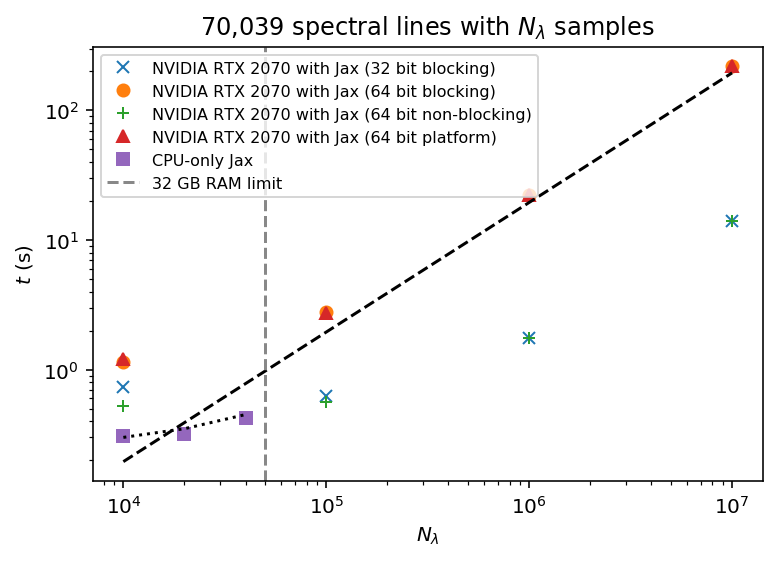

In [35]:
plt.plot(df_gpu_32.nn, df_gpu_32.tt, 'x', label='NVIDIA RTX 2070 with Jax (32 bit blocking)');
plt.plot(df_gpu_block.nn, df_gpu_block.tt, 'o', label='NVIDIA RTX 2070 with Jax (64 bit blocking)'); 
plt.plot(df_gpu_def.nn, df_gpu_def.tt, '+', label='NVIDIA RTX 2070 with Jax (64 bit non-blocking)'); 
plt.plot(df_gpu_plat.nn, df_gpu_plat.tt, '^', label='NVIDIA RTX 2070 with Jax (64 bit platform)');
plt.plot(df_cpu.nn, df_cpu.tt, 's', label='CPU-only Jax'); 
plt.yscale('log'); plt.xscale('log'); plt.xlabel('$N_\lambda$') ; plt.ylabel('$t$ (s)');
plt.plot(df_gpu_plat.nn, 1.95e-5 * df_gpu_plat.nn, 'k--')
plt.plot(df_cpu.nn, 0.25+0.000005 * df_cpu.nn, 'k:');
plt.axvline(50000, linestyle='dashed', color='#888888', label='32 GB RAM limit');
plt.legend(loc='upper left', fontsize=8);
plt.title('70,039 spectral lines with $N_\lambda$ samples');

In [28]:
#pd.DataFrame({'nn':nn, 'tt':tt}).to_csv('../data/GPU_benchmark_64bit_platform.csv')

Awesome!  Ok, I think this figure makes sense.  The CPU is faster (shallower slope) than the CPU, but runs out of memory sooner.  The GPU can support streaming multiprocessors so it trades computation time for memory.

One artificial aspect of this plot that I am still wrapping my head around:

The wall-clock time is the same for either Jax-based (`default`) or `platform` memory allocation, but somehow the Python `time` function concludes different times in the plot above (the green triangles versus the orance circles actually take the same amount of time).   

I think what's happening is that Jax does not block the CPU once a computation is batched to the GPU.  The CPU can continue thinking and doing other tasks, unless the result of that GPU-task is needed (and then the CPU will block).  This think this is the same strategy used in PyTorch: the CPU essentially acts as the orchestrator of the GPU, with a goal of saturating the GPU to 100%.

Most importantly, the 32-bit Jax is much faster than the 64-bit, which makes sense, although again, not as fast as it looks on the plot above.  